<h2 style="font-size:24px; color:white;">Credit Score Prediction</h2>

### Business Understanding

**Business Context Analysis**

Home Credit is currently leveraging various statistical and machine learning techniques to develop credit scoring models. In this project, I was tasked with unlocking the full potential of the available data to enhance the accuracy of credit risk predictions. By doing so, I aim to ensure that creditworthy customers are not mistakenly rejected, and that approved loans are structured with appropriate principals, maturities, and repayment schedules that motivate successful repayment. My analysis is evaluated based on the depth of understanding and the comprehensiveness of the end-to-end approach. I have developed at least two machine learning models, one of which is Logistic Regression. summarizing the modeling process, key insights, and actionable business recommendations.

**Strategic Goal**

Develop a predictive model that estimates the likelihood of customer default based on historical loan application data. Reduce the number of creditworthy customers who are mistakenly rejected (false negatives) and minimize the number of approved loans that result in defaults (false positives). Provide risk segmentation for loan applicants so the company can tailor loan terms (principal, tenor, repayment schedule) according to each risk profile.

**Metrics**

To evaluate the performance of the model and its business impact, the following metrics are used:
Model Evaluation Metrics:
1. AUC-ROC Score – The primary metric for binary classification; it measures the model’s ability to distinguish between defaulters and non-defaulters.
2. Precision – The percentage of predicted defaulters who actually defaulted.
3. Recall – The percentage of actual defaulters that the model successfully identified.
4. F1-score – The harmonic mean of precision and recall, providing a balance between the two.
5. Confusion Matrix – Used to analyze classification errors, especially False Positives and False Negatives.

    AUC-ROC Score – Example Explanation
    
    <img src="image/Capture.jpg"/>
    
    The AUC-ROC (Area Under the Receiver Operating Characteristic Curve) measures the model’s ability to distinguish between positive (defaulter) and negative (non-defaulter) classes.
    - An AUC score of 0.5 indicates no discriminatory power (similar to random guessing).
    - An AUC score of 1.0 indicates perfect classification.
    - Example: If the model has an AUC-ROC score of 0.84, it means there is an 84% chance that the model will correctly distinguish between a randomly selected defaulter and a non-defaulter.

Business Metrics:
1. Reduction in False Negatives – Increases the number of creditworthy customers who are correctly approved.
2. Default Rate per Segment – Assesses actual risk after loans are categorized based on credit scores.
3. Expected Loss Reduction – Represents the potential decrease in financial losses from defaults enabled by the predictive model.

### Exploratory Data Analysis

The following datasets will be utilized in this project:

● application_{train|test}.csv
- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    - Static data for all applications. One row represents one loan in our data sample.
        
● bureau.csv
- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

● bureau_balance.csv
- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau 

● POS_CASH_balance.csv
-  Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has rows.

● credit_card_balance.csv
- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
-  This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) 

● previous_application.csv
- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

● installments_payments.csv
- Repayment history for the previously disbursed credits in Home Credit related to
the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for
missed payment.
- One row is equivalent to one payment of one installment OR one installment
corresponding to one payment of one previous Home Credit credit related to loans
in our sample.

● HomeCredit_columns_description.csv

**Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import RocCurveDisplay
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")



**import data**

In [2]:
train = pd.read_csv("./dataset/application_train.csv")
test = pd.read_csv("./dataset/application_test.csv")
bureau = pd.read_csv("./dataset/bureau.csv")
bureau_balance = pd.read_csv("./dataset/bureau_balance.csv")
credit_card_balance = pd.read_csv("./dataset/credit_card_balance.csv")
installments_payments = pd.read_csv("./dataset/installments_payments.csv")
POS_CASH_balance = pd.read_csv("./dataset/POS_CASH_balance.csv")
previous_application = pd.read_csv("./dataset/previous_application.csv")
columns_description = pd.read_csv("./dataset/HomeCredit_columns_description.csv", index_col=0, encoding='latin1').fillna("-")

**Exploratory Data Analysis**

In [3]:
from typing import Union

def numerical_summary(data: pd.DataFrame, n: int = 4) -> pd.DataFrame:
    mean = pd.DataFrame(data.apply(np.mean)).T
    median = pd.DataFrame(data.apply(np.median)).T

    var = pd.DataFrame(data.apply(np.var)).T
    std = pd.DataFrame(data.apply(np.std)).T
    min_value = pd.DataFrame(data.apply(min)).T
    max_value = pd.DataFrame(data.apply(max)).T
    range_value = pd.DataFrame(data.apply(lambda x: x.max() - x.min())).T
    skewness = pd.DataFrame(data.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(data.apply(lambda x: x.kurtosis())).T
  
    result = pd.concat([min_value, max_value, range_value, mean, median, var, std, skewness, kurtosis]).T.reset_index()
    result.columns = ["attributes","min","max", "range","mean","median", "var", "std","skewness","kurtosis"]
    
    return np.around(result, n)

def data_info(data: Union[pd.DataFrame, pd.Series]) -> pd.DataFrame:
    shape = data.shape
    null_pct = lambda x: np.around(x["Null Count"] * 100/len(data), 3)

    if type(data) == pd.DataFrame:
        info = data.dtypes.reset_index()
        info.columns = ['Attribute', 'Data Type']
        info["Null Count"] = data.isna().sum().values
        info["Null %"] = null_pct(info)
        info["Unique Count"] = data.nunique().values

        unique_value = []
        for col in data:
            unique_value.append(data[col].dropna().unique())
        info["Unique Value"] = unique_value
        
    elif type(data) == pd.Series:
        info = pd.DataFrame([data.name, data.dtype]).T
        info["Null Count"] = data.isna().sum()
        info["Null %"] = null_pct(info)
        info["Unique Count"] = data.nunique()
        info["Unique Value"] = [data.dropna().unique()]
        shape = shape+(1,)
        
    else:
        return "Input DataFrame or Series Only"
    
    print("Total Observation (Rows): %d" %shape[0])
    print("Total Attributes (Columns): %d" %shape[1])
    return info

def val_count(data:pd.Series) -> pd.DataFrame:
   
    if type(data) == pd.Series:
        result = data.value_counts(dropna=False).reset_index()
        result.columns = ["Values", "Count"]
        result["%"] = np.around(result["Count"] * 100/len(data), 3)
        return result
    else:
        return "Input Series only"

In [4]:
data_info(train)

Total Observation (Rows): 307511
Total Attributes (Columns): 122


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,SK_ID_CURR,int64,0,0.000,307511,"[100002, 100003, 100004, 100006, 100007, 10000..."
1,TARGET,int64,0,0.000,2,"[1, 0]"
2,NAME_CONTRACT_TYPE,object,0,0.000,2,"[Cash loans, Revolving loans]"
3,CODE_GENDER,object,0,0.000,3,"[M, F, XNA]"
4,FLAG_OWN_CAR,object,0,0.000,2,"[N, Y]"
...,...,...,...,...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,float64,41519,13.502,9,"[0.0, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 9.0, 8.0]"
118,AMT_REQ_CREDIT_BUREAU_WEEK,float64,41519,13.502,9,"[0.0, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 8.0, 7.0]"
119,AMT_REQ_CREDIT_BUREAU_MON,float64,41519,13.502,24,"[0.0, 1.0, 2.0, 6.0, 5.0, 3.0, 7.0, 9.0, 4.0, ..."
120,AMT_REQ_CREDIT_BUREAU_QRT,float64,41519,13.502,11,"[0.0, 1.0, 2.0, 4.0, 3.0, 8.0, 5.0, 6.0, 7.0, ..."


In [5]:
data_info(test)

Total Observation (Rows): 48744
Total Attributes (Columns): 121


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,SK_ID_CURR,int64,0,0.00,48744,"[100001, 100005, 100013, 100028, 100038, 10004..."
1,NAME_CONTRACT_TYPE,object,0,0.00,2,"[Cash loans, Revolving loans]"
2,CODE_GENDER,object,0,0.00,2,"[F, M]"
3,FLAG_OWN_CAR,object,0,0.00,2,"[N, Y]"
4,FLAG_OWN_REALTY,object,0,0.00,2,"[Y, N]"
...,...,...,...,...,...,...
116,AMT_REQ_CREDIT_BUREAU_DAY,float64,6049,12.41,3,"[0.0, 1.0, 2.0]"
117,AMT_REQ_CREDIT_BUREAU_WEEK,float64,6049,12.41,3,"[0.0, 1.0, 2.0]"
118,AMT_REQ_CREDIT_BUREAU_MON,float64,6049,12.41,7,"[0.0, 1.0, 3.0, 2.0, 6.0, 4.0, 5.0]"
119,AMT_REQ_CREDIT_BUREAU_QRT,float64,6049,12.41,8,"[0.0, 1.0, 3.0, 2.0, 4.0, 5.0, 7.0, 6.0]"


In [6]:
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [7]:
data_info(test)

Total Observation (Rows): 48744
Total Attributes (Columns): 121


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,SK_ID_CURR,int64,0,0.00,48744,"[100001, 100005, 100013, 100028, 100038, 10004..."
1,NAME_CONTRACT_TYPE,object,0,0.00,2,"[Cash loans, Revolving loans]"
2,CODE_GENDER,object,0,0.00,2,"[F, M]"
3,FLAG_OWN_CAR,object,0,0.00,2,"[N, Y]"
4,FLAG_OWN_REALTY,object,0,0.00,2,"[Y, N]"
...,...,...,...,...,...,...
116,AMT_REQ_CREDIT_BUREAU_DAY,float64,6049,12.41,3,"[0.0, 1.0, 2.0]"
117,AMT_REQ_CREDIT_BUREAU_WEEK,float64,6049,12.41,3,"[0.0, 1.0, 2.0]"
118,AMT_REQ_CREDIT_BUREAU_MON,float64,6049,12.41,7,"[0.0, 1.0, 3.0, 2.0, 6.0, 4.0, 5.0]"
119,AMT_REQ_CREDIT_BUREAU_QRT,float64,6049,12.41,8,"[0.0, 1.0, 3.0, 2.0, 4.0, 5.0, 7.0, 6.0]"


In [8]:
data_info(bureau)

Total Observation (Rows): 1716428
Total Attributes (Columns): 17


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,SK_ID_CURR,int64,0,0.000,305811,"[215354, 162297, 402440, 238881, 222183, 42615..."
1,SK_ID_BUREAU,int64,0,0.000,1716428,"[5714462, 5714463, 5714464, 5714465, 5714466, ..."
2,CREDIT_ACTIVE,object,0,0.000,4,"[Closed, Active, Sold, Bad debt]"
3,CREDIT_CURRENCY,object,0,0.000,4,"[currency 1, currency 2, currency 4, currency 3]"
4,DAYS_CREDIT,int64,0,0.000,2923,"[-497, -208, -203, -629, -273, -43, -1896, -11..."
5,CREDIT_DAY_OVERDUE,int64,0,0.000,942,"[0, 2603, 6, 30, 2156, 496, 186, 2264, 41, 8, ..."
6,DAYS_CREDIT_ENDDATE,float64,105553,6.150,14096,"[-153.0, 1075.0, 528.0, 1197.0, 27460.0, 79.0,..."
7,DAYS_ENDDATE_FACT,float64,633653,36.917,2917,"[-153.0, -1710.0, -840.0, -825.0, -187.0, -260..."
8,AMT_CREDIT_MAX_OVERDUE,float64,1124488,65.513,68251,"[77674.5, 0.0, 14985.0, 310.5, 20493.27, 88821..."
9,CNT_CREDIT_PROLONG,int64,0,0.000,10,"[0, 2, 1, 4, 3, 5, 9, 8, 6, 7]"


In [9]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [10]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [11]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [12]:

installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [13]:

POS_CASH_balance 

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [14]:

previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [15]:

columns_description 

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,-
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,-
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,-
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,-
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,-
...,...,...,...,...
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,-
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,-


In [16]:
data_info(credit_card_balance)

Total Observation (Rows): 3840312
Total Attributes (Columns): 23


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,SK_ID_PREV,int64,0,0.000,104307,"[2562384, 2582071, 1740877, 1389973, 1891521, ..."
1,SK_ID_CURR,int64,0,0.000,103558,"[378907, 363914, 371185, 337855, 126868, 38001..."
2,MONTHS_BALANCE,int64,0,0.000,96,"[-6, -1, -7, -4, -5, -3, -2, -19, -13, -18, -1..."
3,AMT_BALANCE,float64,0,0.000,1347904,"[56.97, 63975.555, 31815.225, 236572.11, 45391..."
4,AMT_CREDIT_LIMIT_ACTUAL,int64,0,0.000,181,"[135000, 45000, 450000, 225000, 270000, 585000..."
5,AMT_DRAWINGS_ATM_CURRENT,float64,749816,19.525,2267,"[0.0, 2250.0, 67500.0, 45000.0, 90000.0, 76500..."
6,AMT_DRAWINGS_CURRENT,float64,0,0.000,187005,"[877.5, 2250.0, 0.0, 11547.0, 67500.0, 45000.0..."
7,AMT_DRAWINGS_OTHER_CURRENT,float64,749816,19.525,1832,"[0.0, 137700.0, 177840.0, 46800.0, 187200.0, 2..."
8,AMT_DRAWINGS_POS_CURRENT,float64,749816,19.525,168748,"[877.5, 0.0, 11547.0, 199339.425, 34526.7, 968..."
9,AMT_INST_MIN_REGULARITY,float64,305236,7.948,312266,"[1700.325, 2250.0, 11795.76, 22924.89, 4449.10..."


In [17]:
data_info(installments_payments)

Total Observation (Rows): 13605401
Total Attributes (Columns): 8


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,SK_ID_PREV,int64,0,0.000,997752,"[1054186, 1330831, 2085231, 2452527, 2714724, ..."
1,SK_ID_CURR,int64,0,0.000,339587,"[161674, 151639, 193053, 199697, 167756, 16448..."
2,NUM_INSTALMENT_VERSION,float64,0,0.000,65,"[1.0, 0.0, 2.0, 4.0, 3.0, 5.0, 7.0, 8.0, 6.0, ..."
3,NUM_INSTALMENT_NUMBER,int64,0,0.000,277,"[6, 34, 1, 3, 2, 12, 11, 4, 14, 8, 20, 56, 7, ..."
4,DAYS_INSTALMENT,float64,0,0.000,2922,"[-1180.0, -2156.0, -63.0, -2418.0, -1383.0, -1..."
5,DAYS_ENTRY_PAYMENT,float64,2905,0.021,3039,"[-1187.0, -2156.0, -63.0, -2426.0, -1366.0, -1..."
6,AMT_INSTALMENT,float64,0,0.000,902539,"[6948.36, 1716.525, 25425.0, 24350.13, 2165.04..."
7,AMT_PAYMENT,float64,2905,0.021,944235,"[6948.36, 1716.525, 25425.0, 24350.13, 2160.58..."


In [18]:
data_info(POS_CASH_balance )

Total Observation (Rows): 10001358
Total Attributes (Columns): 8


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,SK_ID_PREV,int64,0,0.000,936325,"[1803195, 1715348, 1784872, 1903291, 2341044, ..."
1,SK_ID_CURR,int64,0,0.000,337252,"[182943, 367990, 397406, 269225, 334279, 34216..."
2,MONTHS_BALANCE,int64,0,0.000,96,"[-31, -33, -32, -35, -38, -39, -34, -41, -37, ..."
3,CNT_INSTALMENT,float64,26071,0.261,73,"[48.0, 36.0, 12.0, 24.0, 60.0, 18.0, 4.0, 42.0..."
4,CNT_INSTALMENT_FUTURE,float64,26087,0.261,79,"[45.0, 35.0, 9.0, 42.0, 12.0, 43.0, 36.0, 16.0..."
5,NAME_CONTRACT_STATUS,object,0,0.000,9,"[Active, Completed, Signed, Approved, Returned..."
6,SK_DPD,int64,0,0.000,3400,"[0, 1, 2, 4, 3, 18, 7, 5, 12, 6, 8, 13, 16, 10..."
7,SK_DPD_DEF,int64,0,0.000,2307,"[0, 1, 2, 4, 3, 18, 7, 5, 12, 8, 13, 10, 15, 6..."


In [19]:
data_info(previous_application)

Total Observation (Rows): 1670214
Total Attributes (Columns): 37


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,SK_ID_PREV,int64,0,0.000,1670214,"[2030495, 2802425, 2523466, 2819243, 1784265, ..."
1,SK_ID_CURR,int64,0,0.000,338857,"[271877, 108129, 122040, 176158, 202054, 19938..."
2,NAME_CONTRACT_TYPE,object,0,0.000,4,"[Consumer loans, Cash loans, Revolving loans, ..."
3,AMT_ANNUITY,float64,372235,22.287,357959,"[1730.43, 25188.615, 15060.735, 47041.335, 319..."
4,AMT_APPLICATION,float64,0,0.000,93885,"[17145.0, 607500.0, 112500.0, 450000.0, 337500..."
5,AMT_CREDIT,float64,1,0.000,86803,"[17145.0, 679671.0, 136444.5, 470790.0, 404055..."
6,AMT_DOWN_PAYMENT,float64,895844,53.636,29278,"[0.0, 12649.5, 1350.0, 9000.0, 13500.0, 4500.0..."
7,AMT_GOODS_PRICE,float64,385515,23.082,93885,"[17145.0, 607500.0, 112500.0, 450000.0, 337500..."
8,WEEKDAY_APPR_PROCESS_START,object,0,0.000,7,"[SATURDAY, THURSDAY, TUESDAY, MONDAY, FRIDAY, ..."
9,HOUR_APPR_PROCESS_START,int64,0,0.000,24,"[15, 11, 7, 9, 8, 10, 12, 13, 14, 16, 6, 4, 5,..."


In [20]:
data_info(columns_description )

Total Observation (Rows): 219
Total Attributes (Columns): 4


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,Table,object,0,0.0,7,"[application_{train|test}.csv, bureau.csv, bur..."
1,Row,object,0,0.0,196,"[SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_..."
2,Description,object,0,0.0,163,"[ID of loan in our sample, Target variable (1 ..."
3,Special,object,0,0.0,8,"[-, normalized , time only relative to the app..."


In [21]:
columns_description[columns_description.Table == "bureau_balance.csv"].iloc[:,1:].reset_index(drop=True)

,Row,Description,Special
0,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
1,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
2,STATUS,Status of Credit Bureau loan during the month ...,-


In [22]:
columns_description[columns_description.Table == "credit_card_balance.csv"].iloc[:,1:].reset_index(drop=True)

,Row,Description,Special
0,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
1,SK_ID_CURR,ID of loan in our sample,hashed
2,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
3,AMT_BALANCE,Balance during the month of previous credit,-
4,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...,-
5,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the ...,-
6,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previou...,-
7,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of t...,-
8,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the mont...,-
9,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the prev...,-


In [23]:
columns_description[columns_description.Table == "installments_payments.csv"].iloc[:,1:].reset_index(drop=True)

,Row,Description,Special
0,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
1,SK_ID_CURR,ID of loan in our sample,hashed
2,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for cred...,-
3,NUM_INSTALMENT_NUMBER,On which installment we observe payment,-
4,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
5,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
6,AMT_INSTALMENT,What was the prescribed installment amount of ...,-
7,AMT_PAYMENT,What the client actually paid on previous cred...,-


In [24]:
columns_description[columns_description.Table == "POS_CASH_balance.csv"].iloc[:,1:].reset_index(drop=True)

,Row,Description,Special
0,SK_ID_PREV,ID of previous credit in Home Credit related t...,-
1,SK_ID_CURR,ID of loan in our sample,-
2,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
3,CNT_INSTALMENT,Term of previous credit (can change over time),-
4,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,-
5,NAME_CONTRACT_STATUS,Contract status during the month,-
6,SK_DPD,DPD (days past due) during the month of previo...,-
7,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,-


In [25]:
columns_description[columns_description.Table == "previous_application.csv"].iloc[:,1:].reset_index(drop=True)

,Row,Description,Special
0,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
1,SK_ID_CURR,ID of loan in our sample,hashed
2,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa...",-
3,AMT_ANNUITY,Annuity of previous application,-
4,AMT_APPLICATION,For how much credit did client ask on the prev...,-
5,AMT_CREDIT,Final credit amount on the previous applicatio...,-
6,AMT_DOWN_PAYMENT,Down payment on the previous application,-
7,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...,-
8,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...,-
9,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...,rounded


In [26]:
columns_description[columns_description.Table == "bureau.csv"].iloc[:,1:].reset_index(drop=True)

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample - one loan in our sam...,hashed
1,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit re...,hashed
2,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,-
3,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded
4,DAYS_CREDIT,How many days before current application did c...,time only relative to the application
5,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the ti...,-
6,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at t...,time only relative to the application
7,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of appl...,time only relative to the application
8,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau cr...,-
9,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit pr...,-


In [27]:
columns_description[columns_description.Table == "application_{train|test}.csv"].iloc[:,1:]

,Row,Description,Special
1,SK_ID_CURR,ID of loan in our sample,-
2,TARGET,Target variable (1 - client with payment diffi...,-
5,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,-
6,CODE_GENDER,Gender of the client,-
7,FLAG_OWN_CAR,Flag if the client owns a car,-
...,...,...,...
120,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,-
121,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,-
122,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,-
123,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,-


### Preprocessing Data

In [28]:
df = pd.read_csv("./dataset/application_test.csv")

In [29]:

missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum()/len(df))*100

missing_df = pd.DataFrame({
    'Missing Data': missing_data,
    'Percentage': missing_percentage.round(2).astype(str) + '%'
})

missing_df.sort_values(by='Percentage', ascending=False, inplace=True)
missing_df

,Missing Data,Percentage
COMMONAREA_AVG,33495,68.72%
COMMONAREA_MODE,33495,68.72%
COMMONAREA_MEDI,33495,68.72%
NONLIVINGAPARTMENTS_AVG,33347,68.41%
NONLIVINGAPARTMENTS_MODE,33347,68.41%
...,...,...
NAME_HOUSING_TYPE,0,0.0%
NAME_FAMILY_STATUS,0,0.0%
NAME_EDUCATION_TYPE,0,0.0%
NAME_INCOME_TYPE,0,0.0%


In [30]:
df = pd.read_csv("./dataset/application_train.csv")

In [31]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum()/len(df))*100

missing_df = pd.DataFrame({
    'Missing Data': missing_data,
    'Percentage': missing_percentage.round(2).astype(str) + '%'
})

missing_df.sort_values(by='Percentage', ascending=False, inplace=True)
missing_df

,Missing Data,Percentage
COMMONAREA_MEDI,214865,69.87%
COMMONAREA_AVG,214865,69.87%
COMMONAREA_MODE,214865,69.87%
NONLIVINGAPARTMENTS_MODE,213514,69.43%
NONLIVINGAPARTMENTS_AVG,213514,69.43%
...,...,...
NAME_FAMILY_STATUS,0,0.0%
NAME_EDUCATION_TYPE,0,0.0%
NAME_INCOME_TYPE,0,0.0%
AMT_ANNUITY,12,0.0%


In [32]:
df = pd.read_csv("./dataset/bureau_balance.csv")

In [33]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum()/len(df))*100

missing_df = pd.DataFrame({
    'Missing Data': missing_data,
    'Percentage': missing_percentage.round(2).astype(str) + '%'
})

missing_df.sort_values(by='Percentage', ascending=False, inplace=True)
missing_df

,Missing Data,Percentage
SK_ID_BUREAU,0,0.0%
MONTHS_BALANCE,0,0.0%
STATUS,0,0.0%


In [34]:
df = pd.read_csv("./dataset/bureau_balance.csv")

In [35]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum()/len(df))*100

missing_df = pd.DataFrame({
    'Missing Data': missing_data,
    'Percentage': missing_percentage.round(2).astype(str) + '%'
})

missing_df.sort_values(by='Percentage', ascending=False, inplace=True)
missing_df

,Missing Data,Percentage
SK_ID_BUREAU,0,0.0%
MONTHS_BALANCE,0,0.0%
STATUS,0,0.0%


In [36]:
df = pd.read_csv("./dataset/credit_card_balance.csv")

In [37]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum()/len(df))*100

missing_df = pd.DataFrame({
    'Missing Data': missing_data,
    'Percentage': missing_percentage.round(2).astype(str) + '%'
})

missing_df.sort_values(by='Percentage', ascending=False, inplace=True)
missing_df

,Missing Data,Percentage
CNT_INSTALMENT_MATURE_CUM,305236,7.95%
AMT_INST_MIN_REGULARITY,305236,7.95%
AMT_PAYMENT_CURRENT,767988,20.0%
AMT_DRAWINGS_ATM_CURRENT,749816,19.52%
CNT_DRAWINGS_POS_CURRENT,749816,19.52%
AMT_DRAWINGS_OTHER_CURRENT,749816,19.52%
AMT_DRAWINGS_POS_CURRENT,749816,19.52%
CNT_DRAWINGS_OTHER_CURRENT,749816,19.52%
CNT_DRAWINGS_ATM_CURRENT,749816,19.52%
SK_ID_PREV,0,0.0%


In [38]:
df = pd.read_csv("./dataset/installments_payments.csv")

In [39]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum()/len(df))*100

missing_df = pd.DataFrame({
    'Missing Data': missing_data,
    'Percentage': missing_percentage.round(2).astype(str) + '%'
})

missing_df.sort_values(by='Percentage', ascending=False, inplace=True)
missing_df

,Missing Data,Percentage
DAYS_ENTRY_PAYMENT,2905,0.02%
AMT_PAYMENT,2905,0.02%
SK_ID_PREV,0,0.0%
SK_ID_CURR,0,0.0%
NUM_INSTALMENT_VERSION,0,0.0%
NUM_INSTALMENT_NUMBER,0,0.0%
DAYS_INSTALMENT,0,0.0%
AMT_INSTALMENT,0,0.0%


**Remove missing values**

In [40]:
missing = df.isnull().any().sum()
print(missing)

2


In [41]:
#"Remove columns with more than 50% missing (null) data."
def drop_columns(df):
  missing_percentage = (df.isnull().sum()/len(df))*100
  columns_to_drop = missing_percentage[missing_percentage > 50].index
  df.drop(columns=columns_to_drop, inplace=True)
  return df

df = drop_columns(df)

In [42]:
unused_columns = [
"SK_ID_CURR",
"OWN_CAR_AGE",
"EXT_SOURCE_1",
"APARTMENTS_AVG",
"BASEMENTAREA_AVG",
"YEARS_BEGINEXPLUATATION_AVG", 
"YEARS_BUILD_AVG", 
"COMMONAREA_AVG", 
"ELEVATORS_AVG", 
"ENTRANCES_AVG", 
"FLOORSMAX_AVG", 
"FLOORSMIN_AVG", 
"LANDAREA_AVG", 
"LIVINGAPARTMENTS_AVG", 
"LIVINGAREA_AVG", 
"NONLIVINGAPARTMENTS_AVG", 
"NONLIVINGAREA_AVG", 
"APARTMENTS_MODE", 
"BASEMENTAREA_MODE", 
"YEARS_BEGINEXPLUATATION_MODE", 
"YEARS_BUILD_MODE", 
"COMMONAREA_MODE", 
"ELEVATORS_MODE", 
"ENTRANCES_MODE", 
"FLOORSMAX_MODE", 
"FLOORSMIN_MODE", 
"LANDAREA_MODE", 
"LIVINGAPARTMENTS_MODE", 
"LIVINGAREA_MODE", 
"NONLIVINGAPARTMENTS_MODE", 
"NONLIVINGAREA_MODE", 
"APARTMENTS_MEDI", 
"BASEMENTAREA_MEDI", 
"YEARS_BEGINEXPLUATATION_MEDI", 
"YEARS_BUILD_MEDI", 
"COMMONAREA_MEDI", 
"ELEVATORS_MEDI", 
"ENTRANCES_MEDI", 
"FLOORSMAX_MEDI", 
"FLOORSMIN_MEDI", 
"LANDAREA_MEDI", 
"LIVINGAPARTMENTS_MEDI", 
"LIVINGAREA_MEDI", 
"NONLIVINGAPARTMENTS_MEDI",
"NONLIVINGAREA_MEDI",
"FONDKAPREMONT_MODE",
"HOUSETYPE_MODE",
"TOTALAREA_MODE",
"WALLSMATERIAL_MODE",
"EMERGENCYSTATE_MODE",
"FLAG_MOBIL",
]

In [43]:
new_train = train.loc[:, ~train.columns.isin(unused_columns)].reset_index()

In [44]:
train.loc[:, ~train.columns.isin(unused_columns)].reset_index().columns

Index(['index', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       

In [45]:
new_train["CODE_GENDER"] = new_train["CODE_GENDER"].replace("XNA",np.nan)
new_train["NAME_FAMILY_STATUS"] = new_train["NAME_FAMILY_STATUS"].replace("Unknown",np.nan)
new_train["OCCUPATION_TYPE"] = new_train["OCCUPATION_TYPE"].replace(np.nan, "XNA")

In [46]:
dropna_columns = [
"NAME_CONTRACT_TYPE", 
"CODE_GENDER", 
"NAME_FAMILY_STATUS",
"CNT_FAM_MEMBERS",
"DAYS_LAST_PHONE_CHANGE"
]
new_train.dropna(subset=dropna_columns, inplace=True)
new_train.reset_index(drop=True, inplace=True)

In [47]:
imp_mode = SimpleImputer(strategy='most_frequent')
imp_median = SimpleImputer(strategy='median')
imp_mean = SimpleImputer(strategy='mean')

attr_mode = ["NAME_TYPE_SUITE"]
attr_median = ["AMT_ANNUITY", "AMT_GOODS_PRICE", 
               "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", 
               "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE",
               "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY",
               "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON",
               "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
attr_mean = ["EXT_SOURCE_2", "EXT_SOURCE_3"]

attr_imp = {'mode': [imp_mode, attr_mode],
            'median': [imp_median, attr_median],
            'mean': [imp_mean, attr_mean]}

for strategy in attr_imp.values():
    for attr in strategy[1]:
        new_train[attr] = strategy[0].fit_transform(new_train[[attr]]).ravel()



**Feature Transformation**

In [48]:
categorical_cols = [col for col in new_train.select_dtypes(include='object')]
data_info(new_train[categorical_cols])

Total Observation (Rows): 307504
Total Attributes (Columns): 12


,Attribute,Data Type,Null Count,Null %,Unique Count,Unique Value
0,NAME_CONTRACT_TYPE,object,0,0.0,2,"[Cash loans, Revolving loans]"
1,CODE_GENDER,object,0,0.0,2,"[M, F]"
2,FLAG_OWN_CAR,object,0,0.0,2,"[N, Y]"
3,FLAG_OWN_REALTY,object,0,0.0,2,"[Y, N]"
4,NAME_TYPE_SUITE,object,0,0.0,7,"[Unaccompanied, Family, Spouse, partner, Child..."
5,NAME_INCOME_TYPE,object,0,0.0,8,"[Working, State servant, Commercial associate,..."
6,NAME_EDUCATION_TYPE,object,0,0.0,5,"[Secondary / secondary special, Higher educati..."
7,NAME_FAMILY_STATUS,object,0,0.0,5,"[Single / not married, Married, Civil marriage..."
8,NAME_HOUSING_TYPE,object,0,0.0,6,"[House / apartment, Rented apartment, With par..."
9,OCCUPATION_TYPE,object,0,0.0,19,"[Laborers, Core staff, Accountants, Managers, ..."


In [49]:
ordinal_mapping ={
    None: 0,
    "Lower secondary": 1,
    "Secondary / secondary special": 2,
    "Incomplete higher": 3,
    "Higher education": 4,
    "Academic degree": 4
}

new_train["NAME_EDUCATION_TYPE"] = new_train["NAME_EDUCATION_TYPE"].replace(ordinal_mapping)

In [50]:
onehot = pd.get_dummies(new_train[[x for x in categorical_cols if x != "NAME_EDUCATION_TYPE"]], drop_first=True)
onehot.head()

,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,False,True,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,True,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


**Transforming numerical feature values to a standard distribution scale**

In [51]:
numerical_cols = [col for col in new_train.columns.tolist() if col not in categorical_cols + ["TARGET"]]
ss = StandardScaler()
std = pd.DataFrame(ss.fit_transform(new_train[numerical_cols]), columns=numerical_cols)
std.head()

,index,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,-1.732067,-0.577538,0.142133,-0.478100,-0.166147,-0.507241,-0.149444,1.506903,-0.456222,0.379844,...,-0.090517,-0.024402,-0.022529,-0.018305,-0.070988,-0.058767,-0.155839,-0.269943,-0.30862,-0.440918
1,-1.732056,-0.577538,0.426793,1.725427,0.592673,1.600855,-1.252737,-0.166804,-0.460122,1.078703,...,-0.090517,-0.024402,-0.022529,-0.018305,-0.070988,-0.058767,-0.155839,-0.269943,-0.30862,-1.007325
2,-1.732044,-0.577538,-0.427188,-1.152887,-1.404662,-1.092146,-0.783440,-0.689493,-0.453306,0.206123,...,-0.090517,-0.024402,-0.022529,-0.018305,-0.070988,-0.058767,-0.155839,-0.269943,-0.30862,-1.007325
3,-1.732033,-0.577538,-0.142527,-0.711433,0.177868,-0.653467,-0.928979,-0.680098,-0.473224,-1.375818,...,-0.090517,-0.024402,-0.022529,-0.018305,-0.070988,-0.058767,-0.155839,-0.269943,-0.30862,-0.440918
4,-1.732022,-0.577538,-0.199459,-0.213741,-0.361751,-0.068562,0.563574,-0.892520,-0.473217,0.191646,...,-0.090517,-0.024402,-0.022529,-0.018305,-0.070988,-0.058767,-0.155839,-0.269943,-0.30862,-1.007325


In [52]:
data_model = pd.concat([onehot, std, new_train["TARGET"]], axis=1)

### Machine Learning Modelling

In [53]:
X = data_model.drop("TARGET", axis=1)
y = data_model["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y, 
                                                    random_state=42)
X_train.shape, X_test.shape
val_count(train.TARGET)

,Values,Count,%
0,0,282686,91.927
1,1,24825,8.073


In [54]:
X_under, y_under = RandomUnderSampler(sampling_strategy=0.5, random_state=42).fit_resample(X_train, y_train)
X_nearmiss, y_nearmiss = RandomUnderSampler(sampling_strategy=0.5, random_state=42).fit_resample(X_train, y_train)
X_over, y_over = RandomOverSampler(sampling_strategy=0.5, random_state=42).fit_resample(X_train, y_train)
X_SMOTE, y_SMOTE = SMOTE(sampling_strategy=0.5, random_state=42).fit_resample(X_train, y_train)

sampler_count = [["Original Data", y_train], ["Undersampling", y_under], 
                 ["NearMiss", y_nearmiss], ["Oversampling", y_over], 
                 ["SMOTE", y_SMOTE]]

for i in sampler_count:
    print(i[0])
    display(val_count(pd.Series(i[1])))

Original Data


,Values,Count,%
0,0,226143,91.927
1,1,19860,8.073


Undersampling


,Values,Count,%
0,0,39720,66.667
1,1,19860,33.333


NearMiss


,Values,Count,%
0,0,39720,66.667
1,1,19860,33.333


Oversampling


,Values,Count,%
0,0,226143,66.667
1,1,113071,33.333


SMOTE


,Values,Count,%
0,0,226143,66.667
1,1,113071,33.333


In [55]:
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

In [56]:
from sklearn.linear_model import LogisticRegression

# build model
logreg_model = LogisticRegression(max_iter=1000)

# train and test model
logreg_model.fit(X_train, y_train)
y_pred_lr = logreg_model.predict(X_test)

# show result
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.44      0.01      0.02      4965

    accuracy                           0.92     61501
   macro avg       0.68      0.50      0.49     61501
weighted avg       0.88      0.92      0.88     61501



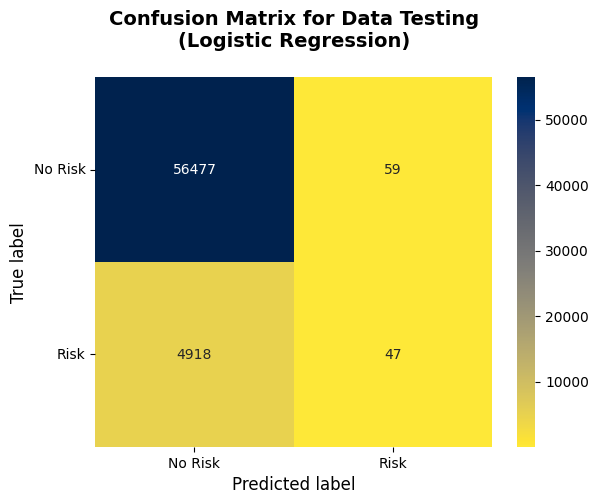

In [57]:
# create confusion matrix as a dataFrame
confusion_matrix_lr = pd.DataFrame((confusion_matrix(y_test, y_pred_lr)), ('No Risk','Risk'),
                                    ('No Risk', 'Risk'))

# plot confusion matrix LR
plt.figure()
heatmap = sns.heatmap(confusion_matrix_lr, annot=True, annot_kws={'size': 10}, fmt='d', cmap='cividis_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center', fontsize=10)

plt.title('Confusion Matrix for Data Testing\n(Logistic Regression)\n', fontsize=14, color='black', weight='bold')
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.show()

**NAIVE BAYES**

In [58]:
from sklearn.metrics import roc_auc_score


In [59]:
roc_auc_lr = round(roc_auc_score(y_test, y_pred_lr),5)
print('ROC AUC:', roc_auc_lr)

ROC AUC: 0.50421


In [60]:
# build model
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

# train and test data
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# show result
print(classification_report(y_test, y_pred_knn))
     

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     56536
           1       0.18      0.02      0.04      4965

    accuracy                           0.91     61501
   macro avg       0.55      0.51      0.50     61501
weighted avg       0.86      0.91      0.88     61501



In [61]:
def model_evaluation(X, y, model, metric):
    skfold = StratifiedKFold(n_splits=5)
    model_cv = cross_val_score(model, X, y, cv=skfold, scoring=metric, n_jobs=-1)
    return model_cv

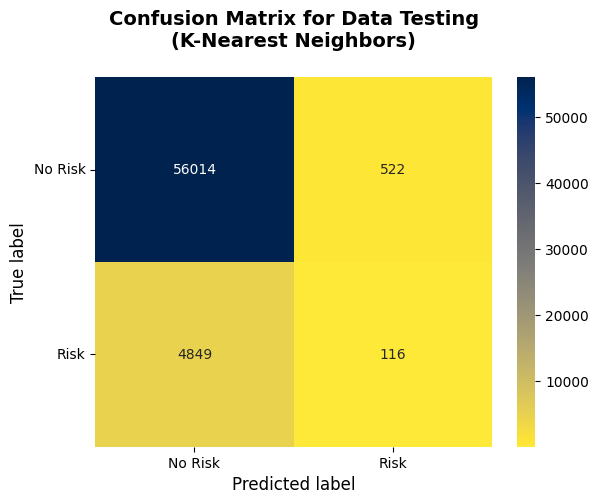

In [62]:
# create confusion matrix as a dataFrame
confusion_matrix_knn = pd.DataFrame((confusion_matrix(y_test, y_pred_knn)), ('No Risk','Risk'),
                                    ('No Risk', 'Risk'))

# plot confusion matrix KNN
plt.figure()
heatmap = sns.heatmap(confusion_matrix_knn, annot=True, annot_kws={'size': 10}, fmt='d', cmap='cividis_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center', fontsize=10)

plt.title('Confusion Matrix for Data Testing\n(K-Nearest Neighbors)\n', fontsize=14, color='black', weight='bold')
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.show()
     

In [63]:
def model_evaluation(X, y, model, metric):
    skfold = StratifiedKFold(n_splits=5)
    model_cv = cross_val_score(model, X, y, cv=skfold, scoring=metric, n_jobs=-1)
    return model_cv

In [64]:
from sklearn.model_selection import cross_val_score
import numpy as np

def model_evaluation(X, y, model, scoring="roc_auc", cv=5):
    """
    Melakukan evaluasi model dengan cross-validation.

    Parameters:
    -----------
    X : array-like
        Fitur data.
    y : array-like
        Label target.
    model : estimator
        Model machine learning.
    scoring : str
        Metode evaluasi (default = "roc_auc").
    cv : int
        Jumlah fold cross-validation (default = 5).

    Returns:
    --------
    float
        Nilai rata-rata skor evaluasi.
    """
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=1)
    return np.mean(scores)


In [65]:
data_model = pd.concat([onehot, std, new_train["TARGET"]], axis=1)

In [66]:
lr_cv_original = model_evaluation(X_train, y_train, lr, "roc_auc")
dt_cv_original = model_evaluation(X_train, y_train, dt, "roc_auc")
rf_cv_original = model_evaluation(X_train, y_train, rf, "roc_auc")
xgb_cv_original = model_evaluation(X_train, y_train, xgb, "roc_auc")

lr_cv_under = model_evaluation(X_under, y_under, lr, "roc_auc")
dt_cv_under = model_evaluation(X_under, y_under, dt, "roc_auc")
rf_cv_under = model_evaluation(X_under, y_under, rf, "roc_auc")
xgb_cv_under = model_evaluation(X_under, y_under, xgb, "roc_auc")

lr_cv_nearmiss = model_evaluation(X_nearmiss, y_nearmiss, lr, "roc_auc")
dt_cv_nearmiss = model_evaluation(X_nearmiss, y_nearmiss, dt, "roc_auc")
rf_cv_nearmiss = model_evaluation(X_nearmiss, y_nearmiss, rf, "roc_auc")
xgb_cv_nearmiss = model_evaluation(X_nearmiss, y_nearmiss, xgb, "roc_auc")

lr_cv_over = model_evaluation(X_over, y_over, lr, "roc_auc")
dt_cv_over = model_evaluation(X_over, y_over, dt, "roc_auc")
rf_cv_over = model_evaluation(X_over, y_over, rf, "roc_auc")
xgb_cv_over = model_evaluation(X_over, y_over, xgb, "roc_auc")

lr_cv_smote = model_evaluation(X_SMOTE, y_SMOTE, lr, "roc_auc")
dt_cv_smote = model_evaluation(X_SMOTE, y_SMOTE, dt, "roc_auc")
rf_cv_smote = model_evaluation(X_SMOTE, y_SMOTE, rf, "roc_auc")
xgb_cv_smote = model_evaluation(X_SMOTE, y_SMOTE, xgb, "roc_auc")

In [67]:
score_mean = [lr_cv_original.mean(), dt_cv_original.mean(),
              rf_cv_original.mean(), xgb_cv_original.mean(),
              
              lr_cv_under.mean(), dt_cv_under.mean(),
              rf_cv_under.mean(), xgb_cv_under.mean(),
              
              lr_cv_nearmiss.mean(), dt_cv_nearmiss.mean(),
              rf_cv_nearmiss.mean(), xgb_cv_nearmiss.mean(),
              
              lr_cv_over.mean(), dt_cv_over.mean(),
              rf_cv_over.mean(), xgb_cv_over.mean(),
              
              lr_cv_smote.mean(), dt_cv_smote.mean(),
              rf_cv_smote.mean(), xgb_cv_smote.mean()]

score_std = [lr_cv_original.std(), dt_cv_original.std(),
              rf_cv_original.std(), xgb_cv_original.std(),
              
              lr_cv_under.std(), dt_cv_under.std(),
              rf_cv_under.std(), xgb_cv_under.std(),
              
              lr_cv_nearmiss.std(), dt_cv_nearmiss.std(),
              rf_cv_nearmiss.std(), xgb_cv_nearmiss.std(),
              
              lr_cv_over.std(), dt_cv_over.std(),
              rf_cv_over.std(), xgb_cv_over.std(),
              
              lr_cv_smote.std(), dt_cv_smote.std(),
              rf_cv_smote.std(), xgb_cv_smote.std()]

method_name = ["Logistic Regression Original", "Decision Tree Original", 
               "Random Forest Original", "XGBoost Original", 
               
               "Logistic Regression Undersampling", "Decision Tree Undersampling", 
               "Random Forest Undersampling", "XGBoost Undersampling", 
               
               "Logistic Regression NearMiss", "Decision Tree NearMiss", 
               "Random Forest NearMiss", "XGBoost NearMiss", 
               
               "Logistic Regression Oversampling", "Decision Tree Oversampling", 
               "Random Forest Oversampling", "XGBoost Oversampling",
               
               "Logistic Regression SMOTE", "Decision Tree SMOTE", 
               "Random Forest SMOTE", "XGBoost SMOTE"]

cv_summary = pd.DataFrame({
    "method": method_name,
    "mean score": score_mean,
    "std score": score_std
})
cv_summary.set_index("method").sort_values(
    ["mean score", "std score"], ascending=False)


,mean score,std score
method,,
Random Forest Oversampling,0.999415,0.0
Random Forest SMOTE,0.974154,0.0
Decision Tree Oversampling,0.949808,0.0
XGBoost SMOTE,0.935063,0.0
Logistic Regression SMOTE,0.916078,0.0
XGBoost Oversampling,0.835206,0.0
Decision Tree SMOTE,0.826636,0.0
Logistic Regression Oversampling,0.741985,0.0
Logistic Regression Original,0.740043,0.0


In [68]:
models = [lr,dt,rf,xgb]
sampler = [[X_train, y_train], [X_under, y_under],
           [X_nearmiss, y_nearmiss], [X_over, y_over], 
           [X_SMOTE, y_SMOTE]]
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]

def y_pred_func(model, X_train, y_train):
    X_train, X_test
    
    model.fit(X_train, y_train)
    return (model, model.predict(X_test), X_test)

In [69]:
# Original Data
score_roc_auc = []
print("Original Data")

for i, j in zip(models, model_names):
    estimator, y_pred, X_test = y_pred_func(i, X_train, y_train)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test, y_predict_proba))
    print(j,'\n', classification_report(y_test, y_pred))

display(pd.DataFrame({"model":model_names,
             "roc_auc score":score_roc_auc}).set_index("model").sort_values(by="roc_auc score",ascending=False))
del score_roc_auc, i, j

Original Data
Logistic Regression 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.45      0.01      0.02      4965

    accuracy                           0.92     61501
   macro avg       0.68      0.50      0.49     61501
weighted avg       0.88      0.92      0.88     61501

Decision Tree 
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     56536
           1       0.14      0.16      0.15      4965

    accuracy                           0.86     61501
   macro avg       0.54      0.54      0.54     61501
weighted avg       0.86      0.86      0.86     61501

Random Forest 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.60      0.00      0.00      4965

    accuracy                           0.92     61501
   macro avg       0.76      0.50      0.48     61501
weight

,roc_auc score
model,
XGBoost,0.746284
Logistic Regression,0.744381
Random Forest,0.712568
Decision Tree,0.538607


In [70]:
# Undersampling Data
score_roc_auc = []
print("Undersampling Data")

for i, j in zip(models, model_names):
    estimator, y_pred, X_test = y_pred_func(i, X_under, y_under)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test, y_predict_proba))
    print(j,'\n', classification_report(y_test, y_pred))

display(pd.DataFrame({"model": model_names,
                      "roc_auc score": score_roc_auc}).set_index("model").sort_values(by="roc_auc score", ascending=False))
del score_roc_auc, i, j


Undersampling Data
Logistic Regression 
               precision    recall  f1-score   support

           0       0.94      0.89      0.92     56536
           1       0.23      0.39      0.29      4965

    accuracy                           0.85     61501
   macro avg       0.59      0.64      0.60     61501
weighted avg       0.89      0.85      0.86     61501

Decision Tree 
               precision    recall  f1-score   support

           0       0.94      0.71      0.81     56536
           1       0.12      0.44      0.19      4965

    accuracy                           0.69     61501
   macro avg       0.53      0.58      0.50     61501
weighted avg       0.87      0.69      0.76     61501

Random Forest 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     56536
           1       0.25      0.31      0.27      4965

    accuracy                           0.87     61501
   macro avg       0.59      0.61      0.60     61501
w

,roc_auc score
model,
Logistic Regression,0.743630
XGBoost,0.743045
Random Forest,0.733057
Decision Tree,0.576275


In [71]:
# NearMiss Data
score_roc_auc = []
print("NearMiss Data")

for i, j in zip(models, model_names):
    estimator, y_pred, X_test = y_pred_func(i, X_nearmiss, y_nearmiss)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test, y_predict_proba))
    print(j,'\n', classification_report(y_test, y_pred))

display(pd.DataFrame({"model": model_names,
                      "roc_auc score": score_roc_auc}).set_index("model").sort_values(by="roc_auc score", ascending=False))
del score_roc_auc, i, j


NearMiss Data
Logistic Regression 
               precision    recall  f1-score   support

           0       0.94      0.89      0.92     56536
           1       0.23      0.39      0.29      4965

    accuracy                           0.85     61501
   macro avg       0.59      0.64      0.60     61501
weighted avg       0.89      0.85      0.86     61501

Decision Tree 
               precision    recall  f1-score   support

           0       0.94      0.71      0.81     56536
           1       0.12      0.44      0.19      4965

    accuracy                           0.69     61501
   macro avg       0.53      0.58      0.50     61501
weighted avg       0.87      0.69      0.76     61501

Random Forest 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     56536
           1       0.25      0.31      0.27      4965

    accuracy                           0.87     61501
   macro avg       0.59      0.61      0.60     61501
weight

,roc_auc score
model,
Logistic Regression,0.743630
XGBoost,0.743045
Random Forest,0.733057
Decision Tree,0.576275


In [72]:
# Oversampling Data
score_roc_auc = []
print("Oversampling Data")

for i, j in zip(models, model_names):
    estimator, y_pred, X_test = y_pred_func(i, X_over, y_over)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test, y_predict_proba))
    print(j,'\n', classification_report(y_test, y_pred))
    
display(pd.DataFrame({"model": model_names,
                      "roc_auc score": score_roc_auc}).set_index("model").sort_values(by="roc_auc score", ascending=False))
del score_roc_auc, i, j


Oversampling Data
Logistic Regression 
               precision    recall  f1-score   support

           0       0.94      0.89      0.91     56536
           1       0.24      0.39      0.29      4965

    accuracy                           0.85     61501
   macro avg       0.59      0.64      0.60     61501
weighted avg       0.89      0.85      0.86     61501

Decision Tree 
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     56536
           1       0.14      0.16      0.15      4965

    accuracy                           0.85     61501
   macro avg       0.53      0.54      0.54     61501
weighted avg       0.86      0.85      0.86     61501

Random Forest 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.58      0.01      0.01      4965

    accuracy                           0.92     61501
   macro avg       0.75      0.50      0.49     61501
we

,roc_auc score
model,
Logistic Regression,0.744288
XGBoost,0.744253
Random Forest,0.726033
Decision Tree,0.537620


In [73]:
# SMOTE Data
score_roc_auc = []
print("SMOTE Data")

for i, j in zip(models, model_names):
    estimator, y_pred, X_test = y_pred_func(i, X_SMOTE, y_SMOTE)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test, y_predict_proba))
    print(j,'\n', classification_report(y_test, y_pred))

display(pd.DataFrame({"model": model_names,
                      "roc_auc score": score_roc_auc}).set_index("model").sort_values(by="roc_auc score", ascending=False))
del score_roc_auc, i, j


SMOTE Data
Logistic Regression 
               precision    recall  f1-score   support

           0       0.92      0.99      0.96     56536
           1       0.40      0.04      0.07      4965

    accuracy                           0.92     61501
   macro avg       0.66      0.52      0.51     61501
weighted avg       0.88      0.92      0.89     61501

Decision Tree 
               precision    recall  f1-score   support

           0       0.93      0.89      0.91     56536
           1       0.13      0.19      0.16      4965

    accuracy                           0.83     61501
   macro avg       0.53      0.54      0.53     61501
weighted avg       0.86      0.83      0.85     61501

Random Forest 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.29      0.02      0.04      4965

    accuracy                           0.92     61501
   macro avg       0.60      0.51      0.50     61501
weighted 

,roc_auc score
model,
XGBoost,0.738457
Random Forest,0.710777
Logistic Regression,0.691370
Decision Tree,0.540295


In [74]:
rf.fit(X_over, y_over)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC-AUC Score", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.58      0.01      0.01      4965

    accuracy                           0.92     61501
   macro avg       0.75      0.50      0.49     61501
weighted avg       0.89      0.92      0.88     61501

ROC-AUC Score 0.7260334403937795


In [75]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Pastikan model rf sudah didefinisikan, misalnya:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Buat pipeline
estimator = Pipeline([
    ('model', rf)
])

# Ruang hyperparameter disederhanakan
hyperparam_space = {
    'model__n_estimators': [100, 150],
    'model__criterion': ['gini'],  # cukup satu dulu untuk efisiensi
    'model__max_depth': [5, 10],
    'model__min_samples_leaf': [5, 10],
    'model__max_features': [20, 30]
}

# Randomized Search CV
randomcv = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=hyperparam_space,
    cv=StratifiedKFold(n_splits=3),  # ubah dari 5 ke 3 untuk efisiensi
    scoring='roc_auc',
    n_iter=5,           # coba 5 kombinasi saja
    n_jobs=-1,
    random_state=42,
    verbose=1           # supaya bisa lihat progres
)

# Fit model
randomcv.fit(X_over, y_over)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'model__criterion': ['gini'],
                                        'model__max_depth': [5, 10],
                                        'model__max_features': [20, 30],
                                        'model__min_samples_leaf': [5, 10],
                                        'model__n_estimators': [100, 150]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [76]:
randomcv.best_estimator_.fit(X_over, y_over)
y_pred_random = randomcv.best_estimator_.predict(X_test)
y_proba_random = randomcv.best_estimator_.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_random))
print("ROC-AUC Score", roc_auc_score(y_test, y_proba_random))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     56536
           1       0.26      0.27      0.27      4965

    accuracy                           0.88     61501
   macro avg       0.60      0.60      0.60     61501
weighted avg       0.88      0.88      0.88     61501

ROC-AUC Score 0.7402756325550967


**Final Model Selected from RandomizedSearchCV Results**

In [77]:
# Ambil model terbaik dari hasil pencarian
best_model = randomcv.best_estimator_

# Tampilkan kombinasi hyperparameter terbaik
print("Best Parameters:", randomcv.best_params_)

# (Opsional) Latih ulang model pada data pelatihan
best_model.fit(X_over, y_over)

# Gunakan model untuk prediksi pada data uji
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # untuk ROC-AUC

# Evaluasi performa
from sklearn.metrics import classification_report, roc_auc_score

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Best Parameters: {'model__n_estimators': 150, 'model__min_samples_leaf': 5, 'model__max_features': 30, 'model__max_depth': 10, 'model__criterion': 'gini'}
ROC AUC Score: 0.7402756325550967
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     56536
           1       0.26      0.27      0.27      4965

    accuracy                           0.88     61501
   macro avg       0.60      0.60      0.60     61501
weighted avg       0.88      0.88      0.88     61501



**Evaluation of the Final Model on the Test Set**

Confusion Matrix:
 [[52660  3876]
 [ 3606  1359]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93     56536
           1       0.26      0.27      0.27      4965

    accuracy                           0.88     61501
   macro avg       0.60      0.60      0.60     61501
weighted avg       0.88      0.88      0.88     61501

ROC AUC Score: 0.7402756325550967


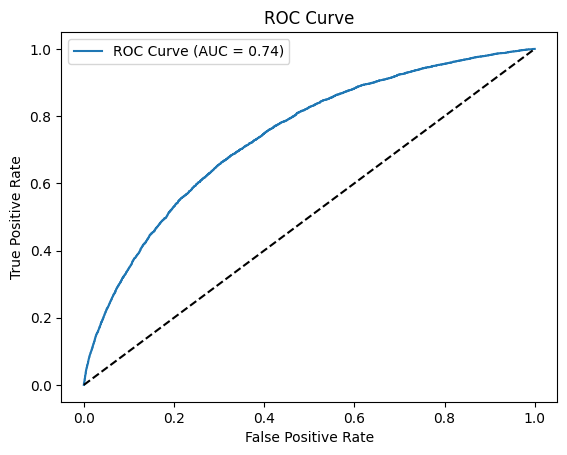

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Ambil model terbaik
best_model = randomcv.best_estimator_

# Prediksi pada data uji
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluasi
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Visualisasi ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


**Reapplying Cross-Validation on the Final Model**

In [79]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, X_over, y_over, cv=5, scoring='roc_auc')
print("Cross-validated ROC AUC scores:", scores)
print("Mean AUC:", scores.mean())


Cross-validated ROC AUC scores: [0.79370593 0.79326118 0.79085304 0.79606208 0.79569375]
Mean AUC: 0.7939151943257506


#### Explaining and Analyzing the Model

**Feature Importance**

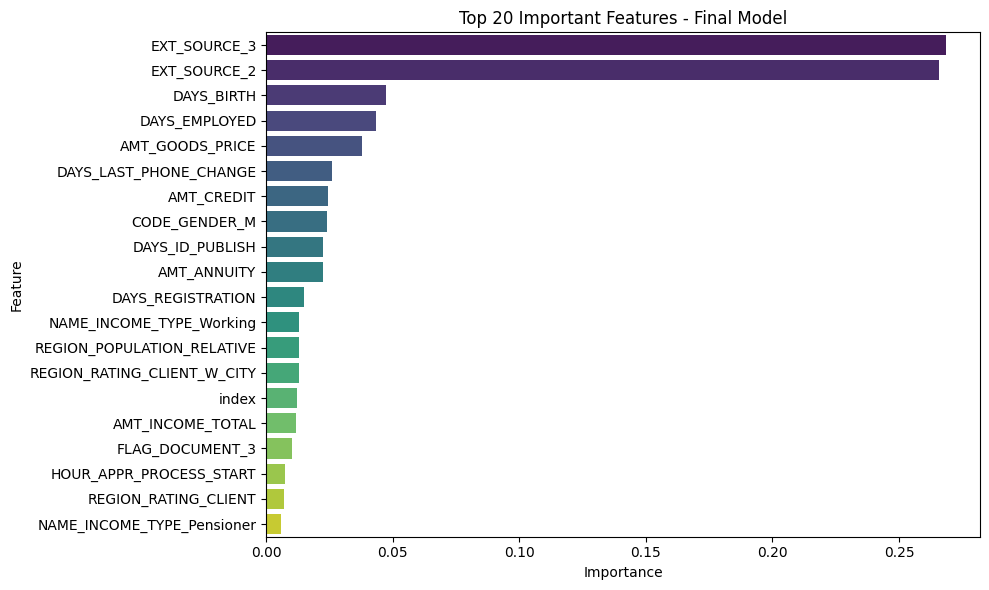

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil nama fitur dan importance dari model terbaik
feature_names = X_train.columns
importances = randomcv.best_estimator_.named_steps["model"].feature_importances_

# Buat DataFrame
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Tampilkan top 20 fitur
plt.figure(figsize=(10, 6))
sns.barplot(data=df_importance.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Important Features - Final Model')
plt.tight_layout()
plt.show()


**SHAP (SHapley Additive Explanations) – Local & Global Interpretation**

Regression or binary classification detected. Visualizing SHAP values.


<Figure size 640x480 with 0 Axes>

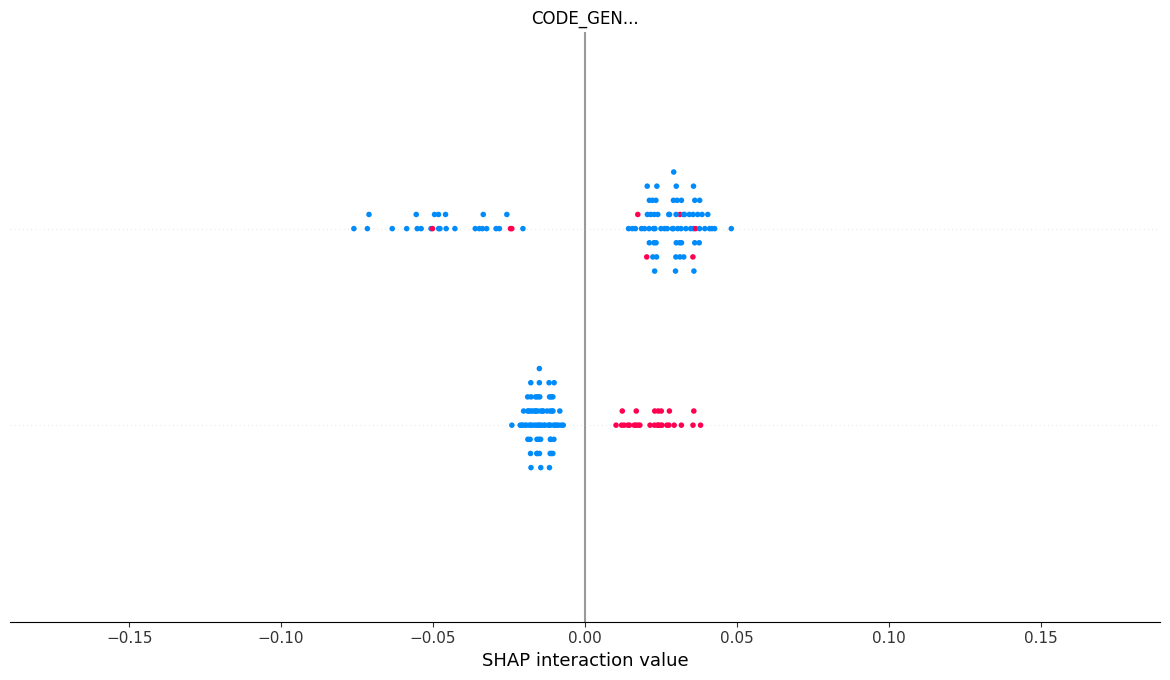

In [82]:
import shap

# Ambil 100 baris dari data uji untuk interpretasi
sample_data = X_test.sample(100, random_state=42)

# Inisialisasi TreeExplainer berdasarkan model hasil RandomizedSearchCV
explainer = shap.TreeExplainer(randomcv.best_estimator_.named_steps["model"])

# Hitung SHAP values
shap_values = explainer.shap_values(sample_data)

# Periksa apakah shap_values berupa list (biasanya untuk klasifikasi)
if isinstance(shap_values, list):
    # Ambil nilai SHAP untuk kelas 1 (misalnya: gagal bayar)
    print("Multiclass or binary classification detected. Visualizing class 1.")
    shap.summary_plot(shap_values[1], sample_data)
else:
    # Untuk regresi atau binary classification (model return 2D array)
    print("Regression or binary classification detected. Visualizing SHAP values.")
    shap.summary_plot(shap_values, sample_data)



### Business Impact Analysis

In [ ]:
# 1. Hitung probabilitas gagal bayar
y_pred_proba = randomcv.best_estimator_.predict_proba(X_test)[:, 1]

# 2. Gabungkan dengan label aktual
df_actual_predicted = pd.DataFrame({
    'y_actual': y_test.values,
    'y_pred_proba': y_pred_proba
})




Business Impact Summary
Total Accepted Loans  : 56266
Total Rejected Loans  : 5235
Bad Loans (Accepted)  : 3606
Total Business Impact : Rp69,260,000,000


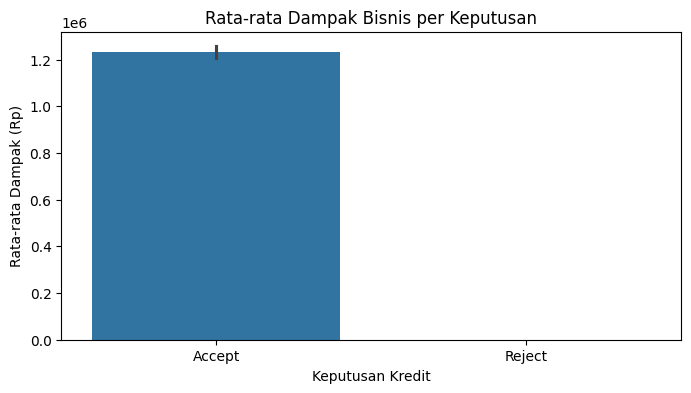

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Buat DataFrame gabungan antara data aktual dan prediksi probabilitas
df_actual_predicted = pd.DataFrame({
    'y_actual': y_test.values,  # label aktual (1 = gagal bayar, 0 = tidak)
    'y_pred_proba': y_pred_proba  # probabilitas gagal bayar
})

# Tentukan threshold keputusan pinjaman
threshold = 0.5
df_actual_predicted['decision'] = df_actual_predicted['y_pred_proba'].apply(
    lambda x: 'Reject' if x > threshold else 'Accept'
)

# Simulasi asumsi bisnis Home Credit
# Misalnya:
# - Jika pinjaman gagal bayar = kerugian Rp 10 juta
# - Jika pinjaman lancar = keuntungan Rp 2 juta
def business_impact(row):
    if row['decision'] == 'Reject':
        return 0  # Tidak ada transaksi
    elif row['y_actual'] == 1:
        return -10_000_000  # Gagal bayar
    else:
        return 2_000_000  # Lancar

df_actual_predicted['business_impact'] = df_actual_predicted.apply(business_impact, axis=1)

# Hitung metrik dampak bisnis
total_impact = df_actual_predicted['business_impact'].sum()
accepted_loans = df_actual_predicted[df_actual_predicted['decision'] == 'Accept'].shape[0]
rejected_loans = df_actual_predicted[df_actual_predicted['decision'] == 'Reject'].shape[0]
bad_loans = df_actual_predicted[(df_actual_predicted['decision'] == 'Accept') & (df_actual_predicted['y_actual'] == 1)].shape[0]

# Tampilkan hasil ringkasan
print("Business Impact Summary")
print("=========================")
print(f"Total Accepted Loans  : {accepted_loans}")
print(f"Total Rejected Loans  : {rejected_loans}")
print(f"Bad Loans (Accepted)  : {bad_loans}")
print(f"Total Business Impact : Rp{total_impact:,.0f}")

# Visualisasi dampak rata-rata
plt.figure(figsize=(8, 4))
sns.barplot(data=df_actual_predicted, x='decision', y='business_impact', estimator=np.mean)
plt.title("Rata-rata Dampak Bisnis per Keputusan")
plt.ylabel("Rata-rata Dampak (Rp)")
plt.xlabel("Keputusan Kredit")
plt.show()


**Threshold Optimization**

In [87]:
from sklearn.metrics import confusion_matrix

thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for t in thresholds:
    y_pred_opt = (y_pred_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()
    
    accepted = tp + fp
    rejected = fn + tn
    bad_loans = fp  # False positives = disetujui tapi gagal bayar
    impact = bad_loans * 20000000  # asumsikan rugi Rp20 juta per gagal bayar

    results.append({
        'Threshold': t,
        'Accepted Loans': accepted,
        'Rejected Loans': rejected,
        'Bad Loans': bad_loans,
        'Estimated Loss (Rp)': impact
    })

df_thresholds = pd.DataFrame(results)
df_thresholds


,Threshold,Accepted Loans,Rejected Loans,Bad Loans,Estimated Loss (Rp)
0,0.10,61093,408,56133,1122660000000
1,0.15,54826,6675,49970,999400000000
2,0.20,43656,17845,39093,781860000000
3,0.25,33266,28235,29115,582300000000
4,0.30,24604,36897,21022,420440000000
5,0.35,17724,43777,14701,294020000000
6,0.40,12526,48975,10069,201380000000
7,0.45,8465,53036,6566,131320000000
8,0.50,5235,56266,3876,77520000000
9,0.55,2958,58543,2075,41500000000


**Model Comparison / Benchmarking**

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_lr_pred = lr.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_lr_pred)


np.float64(0.7444309472947108)

### Business Recommendations

**Insight: Borrowers with High Income Are More Vulnerable to Default**

Shape of y_pred_proba: (61501,)


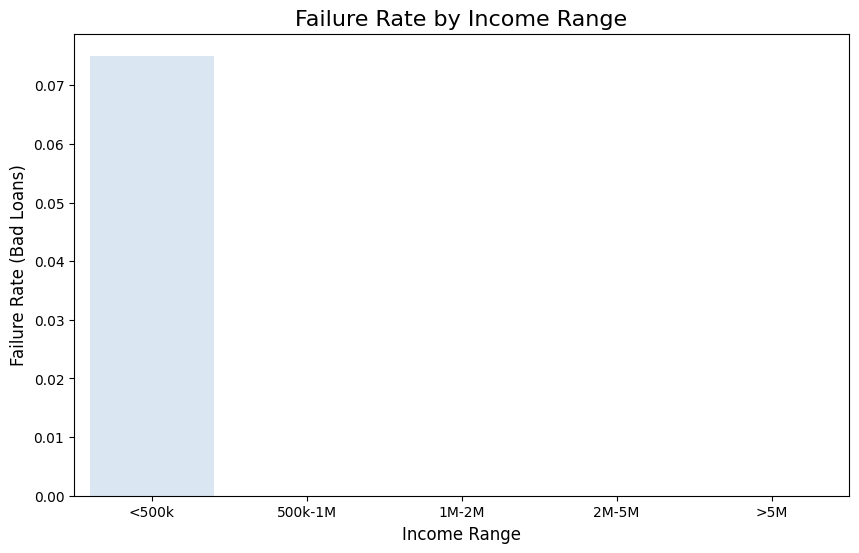

Failure Rate by Income Range:
income_range
<500k      0.075052
500k-1M         NaN
1M-2M           NaN
2M-5M           NaN
>5M             NaN
Name: y_actual, dtype: float64


In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asumsikan X_test memiliki kolom 'AMT_INCOME_TOTAL' (pendapatan) dan 'y_actual' (status gagal bayar: 1 = gagal bayar, 0 = tidak)
# Juga asumsikan y_pred_proba adalah probabilitas prediksi model (misalnya prediksi risiko gagal bayar)

# Cek dimensi y_pred_proba
print(f"Shape of y_pred_proba: {y_pred_proba.shape}")

# Buat DataFrame untuk analisis
df_analysis = pd.DataFrame({
    'income': X_test['AMT_INCOME_TOTAL'],  # Kolom pendapatan dari data uji
    'y_actual': y_test,  # Label gagal bayar (1 = gagal bayar, 0 = tidak)
})

# Jika y_pred_proba adalah array dua dimensi, pilih kolom kedua (probabilitas untuk kelas 1)
if len(y_pred_proba.shape) > 1:
    df_analysis['y_pred_proba'] = y_pred_proba[:, 1]  # Probabilitas gagal bayar (kelas 1)
else:
    df_analysis['y_pred_proba'] = y_pred_proba  # Jika satu dimensi, gunakan langsung

# Kelompokkan data berdasarkan rentang pendapatan
income_bins = [0, 500000, 1000000, 2000000, 5000000, np.inf]  # Menentukan rentang pendapatan
income_labels = ['<500k', '500k-1M', '1M-2M', '2M-5M', '>5M']

df_analysis['income_range'] = pd.cut(df_analysis['income'], bins=income_bins, labels=income_labels)

# Hitung rasio gagal bayar untuk setiap rentang pendapatan
fail_rate_by_income = df_analysis.groupby('income_range')['y_actual'].mean()

# Visualisasi rasio gagal bayar berdasarkan rentang pendapatan
plt.figure(figsize=(10, 6))
sns.barplot(x=fail_rate_by_income.index, y=fail_rate_by_income.values, palette='Blues')
plt.title('Failure Rate by Income Range', fontsize=16)
plt.xlabel('Income Range', fontsize=12)
plt.ylabel('Failure Rate (Bad Loans)', fontsize=12)
plt.show()

# Tampilkan informasi hasil analisis
print("Failure Rate by Income Range:")
print(fail_rate_by_income)


**Segmentation Based on Borrower's Age**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cek apakah kolom 'DAYS_BIRTH' tersedia
if 'DAYS_BIRTH' not in X_test.columns:
    raise KeyError("Kolom 'DAYS_BIRTH' tidak ditemukan dalam X_test.")

# Pastikan y_test memiliki indeks yang sama dengan X_test
y_test = y_test.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

# Buat DataFrame analisis
df_age_analysis = pd.DataFrame({
    'age': (-X_test_reset['DAYS_BIRTH']) // 365,  # Konversi dari hari ke tahun
    'y_actual': y_test  # 1 = gagal bayar, 0 = tidak
})

# Buat kategori umur
age_bins = [18, 25, 35, 50, 60, np.inf]
age_labels = ['<25', '25-34', '35-49', '50-59', '60+']
df_age_analysis['age_group'] = pd.cut(df_age_analysis['age'], bins=age_bins, labels=age_labels, right=False)

# Hitung rasio gagal bayar per kelompok umur
fail_rate_by_age = df_age_analysis.groupby('age_group')['y_actual'].mean()

# Tampilkan hasil
print("Failure Rate by Age Group:")
print(fail_rate_by_age)

# Visualisasi
plt.figure(figsize=(8, 5))
sns.barplot(x=fail_rate_by_age.index, y=fail_rate_by_age.values, palette='coolwarm')
plt.title('Failure Rate Berdasarkan Kelompok Umur')
plt.ylabel('Tingkat Gagal Bayar')
plt.xlabel('Kelompok Umur')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


NameError: name 'X_test' is not defined